https://github.com/uscensusbureau/acs-summary-file/wiki/Python-Table-Data-for-All-Tracts

According to the [data explorer notes](https://data.census.gov/table/ACSDT5Y2020.B16001?q=B16001:%20Language%20Spoken%20at%20Home%20by%20Ability%20to%20Speak%20English%20for%20the%20Population%205%20Years%20and%20Over), Public Use Microdata Sample Areas (PUMAs) (795) are the most precise available version of this dataset (for privacy reasons). More info about PUMAs [here](https://www.census.gov/programs-surveys/geography/guidance/geo-areas/pumas.htm).

In [93]:
import pandas as pd
from ftplib import FTP
import os, sys
import geopandas as gpd
import matplotlib as mpl

In [66]:
def table_for_sumlevel(tblid, year, dataset, sumlevel):

    #create output directory. 
    outdir = 'output'
    try:
        os.mkdir(outdir)
    except FileExistsError as e:
        print(f"directory named '{outdir}' already exists. delete it and try again.")
        sys.exit(1)

    dir =f"/programs-surveys/acs/summary_file/{year}/prototype/{dataset}YRData/"

    #go to ftp site
    ftp = FTP("ftp2.census.gov")
    ftp.login("","")
    ftp.cwd(dir)

    #get .dat file based on tblid or all tables
    files = [x for x in ftp.nlst() if f"{tblid}.dat" in x or (tblid=="*" and ".dat" in x)]

    for file in files:
        #read data file and query for summary level (http faster than ftp)
        df = pd.read_csv(f"https://www2.census.gov{dir}{file}", sep="|")
        df = df[ df['GEO_ID'].str.startswith(sumlevel) ]

        #output
        if not df.empty:
            df.to_csv(f"{outdir}/{file}", sep="|", index=False)
            print(f"{outdir}/{file} output.")

[Summary level definitions](https://mcdc.missouri.edu/geography/sumlevs/#:~:text=the%20U.S.-,Summary%20Levels,-All%20MCDC%20census)

In [67]:
#get all tables for all tracts

table_for_sumlevel(tblid = 'b16001', year=2020, dataset=5, sumlevel='795')

output/acsdt5y2020-b16001.dat output.


I need to re-do this workflow and instead of saving a .dat to an output directory and re-loading it, I can directly load it as a df

`GEO_ID` [explanation ](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html#:~:text=The%20%E2%80%9CGEO.ID%E2%80%9D%20field%20contains%2014%2Ddigit%20codes%20that%20identify%20the%20summary%20level%20of%20data%2C%20the%20geographic%20component%20of%20the%20data%20and%20FIPS%20codes%20that%20uniquely%20identify%20the%20data)

In [120]:
df = pd.read_csv('output/acsdt5y2020-b16001.dat', delimiter='|')
# Take last 7 digits of GEO_ID to make new column that matches the shapefile parameter 
df['GEO_ID_SHORT'] = df.GEO_ID.str[-7:]
df['ONLY_ENG_PER'] = (df.B16001_E002 / df.B16001_E001)
df

,GEO_ID,B16001_E001,B16001_M001,B16001_E002,B16001_M002,B16001_E003,B16001_M003,B16001_E004,B16001_M004,B16001_E005,...,B16001_E125,B16001_M125,B16001_E126,B16001_M126,B16001_E127,B16001_M127,B16001_E128,B16001_M128,GEO_ID_SHORT,ONLY_ENG_PER
0,7950000US0100100,176182,664,167061,861,7098,471,3281,480,3817,...,0,29,113,117,14,23,99,113,0100100,0.948230
1,7950000US0100200,186045,2183,176748,2399,5840,794,3685,633,2155,...,0,29,68,80,34,54,34,52,0100200,0.950028
2,7950000US0100301,126916,2620,115383,3005,5516,793,3391,578,2125,...,0,29,32,37,18,30,14,22,0100301,0.909129
3,7950000US0100302,95918,2091,88273,2217,4493,739,2129,431,2364,...,0,29,61,78,36,50,25,41,0100302,0.920297
4,7950000US0100400,116264,167,106516,588,9255,552,5396,569,3859,...,0,29,0,29,0,29,0,29,0100400,0.916156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2373,7950000US7200902,134415,604,6061,683,128238,828,21233,1347,107005,...,0,34,0,34,0,34,0,34,7200902,0.045092
2374,7950000US7201001,121932,-555555555,7187,743,114680,760,22465,1558,92215,...,0,34,0,34,0,34,0,34,7201001,0.058943
2375,7950000US7201002,152987,-555555555,8051,1307,144785,1297,29655,1981,115130,...,0,34,0,34,0,34,0,34,7201002,0.052625
2376,7950000US7201101,113396,337,5585,779,107527,917,20893,1504,86634,...,0,34,0,34,0,34,0,34,7201101,0.049252


Table header labels [here](https://www2.census.gov/programs-surveys/acs/summary_file/2020/prototype/)

In [123]:
# issue with default encoding, so I'm "replacing" the text with issues (see https://docs.python.org/3/library/codecs.html#error-handlers)
df2 = pd.read_csv('ACS2020_Table_Shells.csv', encoding_errors="replace")
labels = df2[df2['Table ID'] == 'B16001']
labels

,Table ID,Line,Unique ID,Stub,Data Release
12470,B16001,,NaN,LANGUAGE SPOKEN AT HOME BY ABILITY TO SPEAK EN...,"1,5"
12471,B16001,,NaN,Universe: Population 5 years and over,NaN
12472,B16001,1,B16001_001,Total:,NaN
12473,B16001,2,B16001_002,Speak only English,NaN
12474,B16001,3,B16001_003,Spanish:,NaN
...,...,...,...,...,...
12595,B16001,124,B16001_124,"Speak English ""very well""",NaN
12596,B16001,125,B16001_125,"Speak English less than ""very well""",NaN
12597,B16001,126,B16001_126,Other and unspecified languages:,NaN
12598,B16001,127,B16001_127,"Speak English ""very well""",NaN


Add [2020 shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.2020.html#list-tab-1883739534) at 5m resolution (to then get puma_500k)

In [124]:
shp = gpd.read_file('geos/cb_2020_us_puma20_500k.zip')
shp

,STATEFP20,PUMACE20,AFFGEOID20,GEOID20,NAMELSAD20,STUSPS20,ST_NAME20,LSAD20,ALAND20,AWATER20,geometry
0,26,03003,795P200US2603003,2603003,Macomb County (Southwest)--Sterling Heights Ci...,MI,Michigan,P0,94387916,712140,"POLYGON ((-83.09145 42.62421, -83.07181 42.624..."
1,26,03213,795P200US2603213,2603213,Wayne County (Northeast)--I-94 Corridor PUMA,MI,Michigan,P0,60673543,77502426,"MULTIPOLYGON (((-83.03388 42.37928, -83.03269 ..."
2,18,03000,795P200US1803000,1803000,Bartholomew & Jackson Counties--Columbus City ...,IN,Indiana,P0,2374805320,16889149,"POLYGON ((-86.31813 39.04881, -86.29980 39.048..."
3,27,00301,795P200US2700301,2700301,"Cook, Lake & St. Louis (North) Counties PUMA",MN,Minnesota,P0,23430251026,8670578293,"MULTIPOLYGON (((-89.59206 47.96668, -89.59147 ..."
4,36,00703,795P200US3600703,3600703,Onondaga County (Central)--Syracuse City (Oute...,NY,New York,P0,516064463,12510055,"POLYGON ((-76.46299 43.00612, -76.45711 43.006..."
...,...,...,...,...,...,...,...,...,...,...,...
2482,39,00705,795P200US3900705,3900705,"Cuyahoga County (South)--Strongsville, North R...",OH,Ohio,P0,227987176,686363,"POLYGON ((-81.87801 41.28301, -81.87791 41.290..."
2483,48,01600,795P200US4801600,4801600,East Texas COG (Central)--Gregg County (Longvi...,TX,Texas,P0,708052150,6206460,"POLYGON ((-94.98694 32.43646, -94.98671 32.450..."
2484,39,00706,795P200US3900706,3900706,"Cuyahoga County (Southeast)--Garfield Heights,...",OH,Ohio,P0,137260792,1394137,"POLYGON ((-81.68546 41.41942, -81.68461 41.419..."
2485,34,01405,795P200US3401405,3401405,Essex County (Central)--Orange & East Orange PUMA,NJ,New Jersey,P0,15903210,5154,"POLYGON ((-74.25429 40.76006, -74.25290 40.761..."


In [127]:
# merge shp file and survey data, turn it into a GeoDataFrame
joined = gpd.GeoDataFrame(pd.merge(df, shp, left_on='GEO_ID_SHORT', right_on='GEOID20'))
joined

Index(['GEO_ID', 'B16001_E001', 'B16001_M001', 'B16001_E002', 'B16001_M002',
       'B16001_E003', 'B16001_M003', 'B16001_E004', 'B16001_M004',
       'B16001_E005',
       ...
       'PUMACE20', 'AFFGEOID20', 'GEOID20', 'NAMELSAD20', 'STUSPS20',
       'ST_NAME20', 'LSAD20', 'ALAND20', 'AWATER20', 'geometry'],
      dtype='object', length=270)

<Axes: >

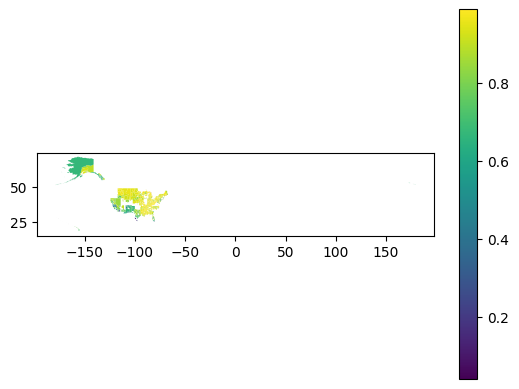

In [128]:
joined.plot("ONLY_ENG_PER", legend=True)